# FINM 36700 Portfolio and Risk Management
# Homework 5 Solutions
Submitted by:
Vidhan Ajmera

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from arch import arch_model
from arch.univariate import GARCH, EWMAVariance 
from sklearn import linear_model
import scipy.stats as stats
from statsmodels.regression.rolling import RollingOLS
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.precision", 4)
sns.set(rc={'figure.figsize':(15, 10)})

# Q2 The Factors

2.1: Analyze the factors, similar to how you analyzed the three Fama-French factors in Homework 4. You now have three additional factors, so let’s compare there univariate statistics.

In [5]:
factors = pd.read_excel('/Users/vidhanajmera/Desktop/Portfolio and Risk Management/finm-portfolio-2022/data/factor_pricing_data.xlsx', sheet_name = 1)
factors = factors.set_index('Date')
factors.dropna(inplace=True)

In [7]:
factors.head()

,MKT,SMB,HML,RMW,CMA,UMD
Date,,,,,,
1980-01-31,0.0551,0.0183,0.0175,-0.0170,0.0164,0.0755
1980-02-29,-0.0122,-0.0157,0.0061,0.0004,0.0268,0.0788
1980-03-31,-0.1290,-0.0693,-0.0101,0.0146,-0.0119,-0.0955
1980-04-30,0.0397,0.0105,0.0106,-0.0210,0.0029,-0.0043
1980-05-31,0.0526,0.0211,0.0038,0.0034,-0.0031,-0.0112


In [8]:
factors.describe()

,MKT,SMB,HML,RMW,CMA,UMD
count,512.0000,512.0000,512.0000,512.0000,512.0000,512.0000
mean,0.0069,0.0010,0.0023,0.0037,0.0028,0.0055
std,0.0452,0.0290,0.0314,0.0241,0.0206,0.0446
min,-0.2324,-0.1535,-0.1397,-0.1873,-0.0694,-0.3430
25%,-0.0196,-0.0158,-0.0156,-0.0075,-0.0101,-0.0114
50%,0.0115,0.0002,0.0009,0.0033,0.0009,0.0065
75%,0.0349,0.0187,0.0176,0.0138,0.0149,0.0289
max,0.1365,0.1834,0.1275,0.1309,0.0905,0.1820


In [11]:
def stats_dates(df, dates, annual_fac=12):
    stats_df = pd.DataFrame(data=None, index = ['Mean', 'Volatility', 'Sharpe Ratio', 'VaR (.05)'])
    
    for d in dates:
        for col in df.columns:
            df_ = df.loc[d[0]:d[1], col]
            stats_df[col + ' ' + d[0] + '-' + d[1]] = [df_.mean()*annual_fac,
                                                       df_.std()*np.sqrt(annual_fac),
                                                       (df_.mean()/df_.std())*np.sqrt(annual_fac),
                                                       df_.quantile(.05)]
    
    return stats_df

def summary_stats(df, annual_fac=12):
    ss_df = (df.mean() * annual_fac).to_frame('Mean')
    ss_df['Volatility'] = df.std() * np.sqrt(annual_fac)
    ss_df['Sharpe Ratio'] = ss_df['Mean'] / ss_df['Volatility']
    
    return round(ss_df, 4)


In [12]:
summary_stats(factors)

,Mean,Volatility,Sharpe Ratio
MKT,0.0831,0.1567,0.5305
SMB,0.0122,0.1005,0.1211
HML,0.0275,0.1088,0.2529
RMW,0.0448,0.0834,0.5376
CMA,0.0333,0.0715,0.4652
UMD,0.0655,0.1545,0.4241


2. Based on the factor statistics above, answer the following.\
(a) Does each factor have a positive risk premium (positive expected excess return)?\
(b) How have the factors performed since the time of the case, (2015-present)?

Sol: Part-2(a) Over the entire period all of the factors have a positive risk premium.

Periods explored in HW 4:

In [15]:
stats_dates(factors, [['1926','1980'],['1981','2001'],['2002','2022']])

,MKT 1926-1980,SMB 1926-1980,HML 1926-1980,RMW 1926-1980,CMA 1926-1980,UMD 1926-1980,MKT 1981-2001,SMB 1981-2001,HML 1981-2001,RMW 1981-2001,CMA 1981-2001,UMD 1981-2001,MKT 2002-2022,SMB 2002-2022,HML 2002-2022,RMW 2002-2022,CMA 2002-2022,UMD 2002-2022
Mean,0.2029,0.0537,-0.1987,0.1078,-0.0977,0.3078,0.0773,0.0014,0.0637,0.0469,0.0531,0.1017,0.0833,0.0211,0.0017,0.0397,0.0194,0.0170
Volatility,0.2037,0.1088,0.1178,0.0730,0.0769,0.2346,0.1574,0.1097,0.1113,0.0917,0.0773,0.1451,0.1540,0.0901,0.1045,0.0747,0.0642,0.1581
Sharpe Ratio,0.9960,0.4935,-1.6874,1.4760,-1.2699,1.3121,0.4908,0.0131,0.5727,0.5113,0.6874,0.7008,0.5409,0.2337,0.0161,0.5313,0.3023,0.1078
VaR (.05),-0.0829,-0.0494,-0.0727,-0.0188,-0.0406,-0.0797,-0.0645,-0.0435,-0.0418,-0.0303,-0.0299,-0.0610,-0.0788,-0.0395,-0.0410,-0.0264,-0.0238,-0.0711


2015 - present

In [16]:
stats_dates(factors, [['2015','2022']])

,MKT 2015-2022,SMB 2015-2022,HML 2015-2022,RMW 2015-2022,CMA 2015-2022,UMD 2015-2022
Mean,0.1069,-0.0058,-0.0197,0.0395,0.0022,0.0255
Volatility,0.1602,0.0977,0.1325,0.0712,0.0796,0.1368
Sharpe Ratio,0.6676,-0.0590,-0.1488,0.5553,0.0282,0.1865
VaR (.05),-0.0788,-0.0419,-0.0482,-0.0233,-0.0267,-0.0644


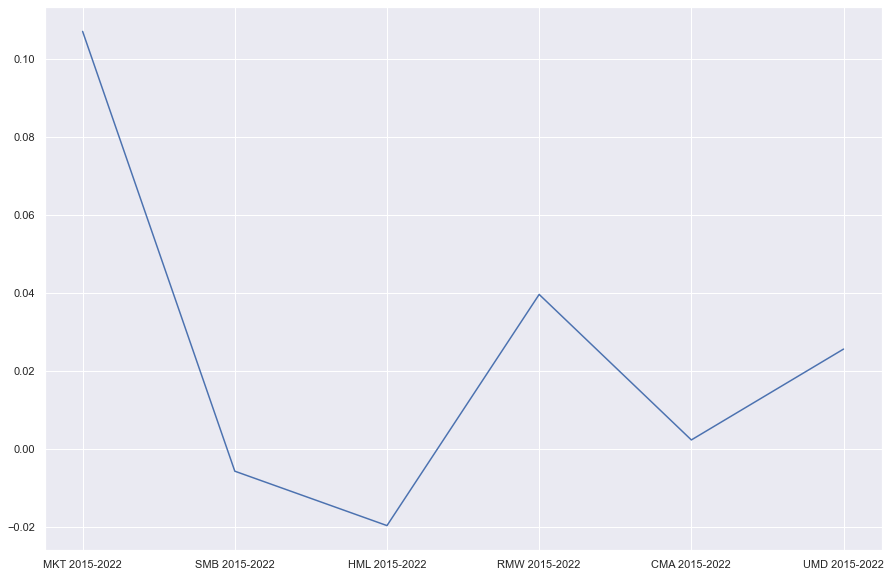

In [33]:
x=stats_dates(factors, [['2015','2022']])
#x=x.T
x.iloc[0].plot()
plt.show()

Sol: 2(b) RMW, UMD and CMA are the only factors apart from the market factor that have had positive risk premia. Value (HML) has notably underperformed.

3. Report the correlation matrix across the six factors.\
(a) Does the construction method succeed in keeping correlations small?\
(b) Fama and French say that HML is somewhat redundant in their 5-factor model. Does this seem to be the case?\

In [35]:
factors.corr()

,MKT,SMB,HML,RMW,CMA,UMD
MKT,1.0000,0.2263,-0.2221,-0.2554,-0.3819,-0.1677
SMB,0.2263,1.0000,-0.0721,-0.4143,-0.0642,-0.0304
HML,-0.2221,-0.0721,1.0000,0.2295,0.6725,-0.2349
RMW,-0.2554,-0.4143,0.2295,1.0000,0.1155,0.0753
CMA,-0.3819,-0.0642,0.6725,0.1155,1.0000,-0.0122
UMD,-0.1677,-0.0304,-0.2349,0.0753,-0.0122,1.0000


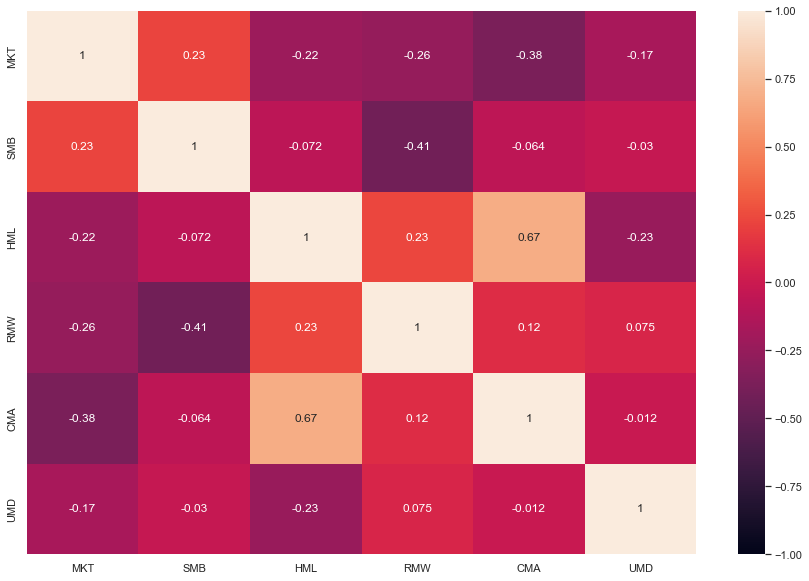

In [40]:
sns.heatmap(factors.corr(), vmin=-1, vmax=1,annot=True);

In [43]:
x1=factors.corr().unstack()
x1.nlargest(7)

MKT  MKT    1.0000
SMB  SMB    1.0000
HML  HML    1.0000
RMW  RMW    1.0000
CMA  CMA    1.0000
UMD  UMD    1.0000
HML  CMA    0.6725
dtype: float64

Sol: 3(a) Yes, correlations between factors are kept relatively small. The largest correlation is 0.6725(between HML and CMA), which is much higher than the other correlations.

Sol: 3(b) Yes, HML is highly correlated to CMA (this is the 0.6725 correlation).

4. Report the tangency weights for a portfolio of these 6 factors.\
(a) Which factors seem most important? And Least?\
(b) Are the factors with low mean returns still useful?\
(c) Re-do the tangency portfolio, but this time only include MKT, SMB, HML, and UMD. Which factors get high/low tangency weights now?\
What do you conclude about the importance or unimportance of these styles?

In [50]:
def compute_tangency(df_tilde, diagonalize_Sigma=False):

    Sigma = df_tilde.cov()

    # N is the number of assets

    N = Sigma.shape[0]

    Sigma_adj = Sigma.copy()

    if diagonalize_Sigma:

        Sigma_adj.loc[:,:] = np.diag(np.diag(Sigma_adj))



    mu_tilde = df_tilde.mean()

    Sigma_inv = np.linalg.inv(Sigma_adj)

    weights = Sigma_inv @ mu_tilde / (np.ones(N) @ Sigma_inv @ mu_tilde)

    # For convenience, I'll wrap the solution back into a pandas.Series object.

    omega_tangency = pd.Series(weights, index=mu_tilde.index)

    return omega_tangency, mu_tilde, Sigma_adj



omega_tangency, mu_tilde, Sigma = compute_tangency(factors)

z=omega_tangency.to_frame('Tangency Weights')
z

,Tangency Weights
MKT,0.2011
SMB,0.0816
HML,-0.0470
RMW,0.2884
CMA,0.3774
UMD,0.0986


Sol: 4(a): CMA, RMW, and the MKT seem like the most important factors as they have the largest weights. SMB, HML, and UMD have lower/negative weights so we could say that they seem less important.

In [55]:
x2=summary_stats(factors)
z22=z.join(x2)
z22=z22.drop(['Volatility','Sharpe Ratio'],axis=1)
z22.sort_values(by=['Mean'])

,Tangency Weights,Mean
SMB,0.0816,0.0122
HML,-0.0470,0.0275
CMA,0.3774,0.0333
RMW,0.2884,0.0448
UMD,0.0986,0.0655
MKT,0.2011,0.0831


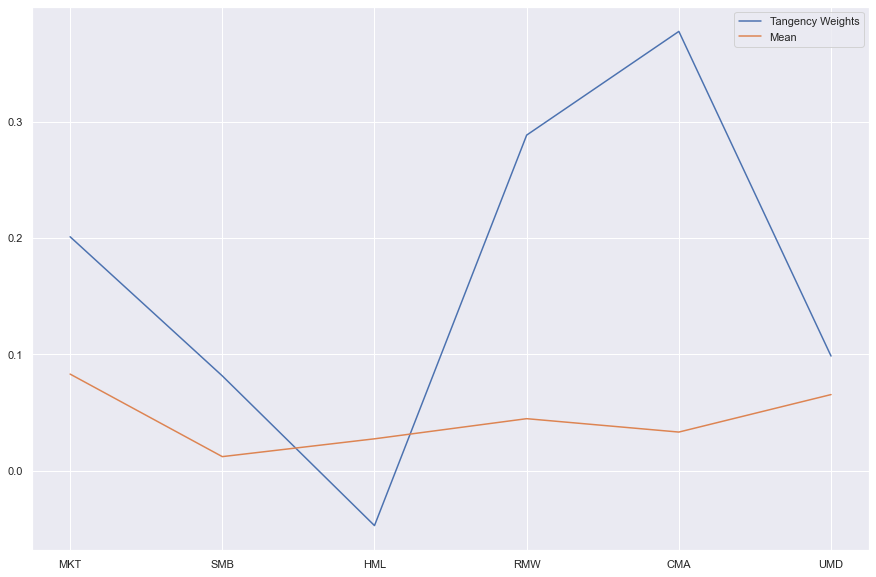

In [56]:
z22.plot()
plt.show()

Sol: 4(b) Yes, CMA has one of the lower mean returns but the highest allocation. RMW also has lower mean with higher allocation. There is not linear relationship between mean and tangency portfolio weights, as can be seen from the plot


In [57]:
omega_tangency2, mu_tilde2, Sigma2 = compute_tangency(factors[['MKT','SMB','HML','UMD']])

omega_tangency2.to_frame('Tangency Weights')

,Tangency Weights
MKT,0.3314
SMB,0.0061
HML,0.3622
UMD,0.3003


Sol:4(c) HML has the highest tangency weight once we remove CMA. This makes sense as CMA had the largest weight before, and is quite correlated to HML. SMB has a very small weight compared to eariler.

What do you conclude about the importance or unimportance of these styles?\

We can conclude that the importance of these styles is very much based on correlation between the factors. After removing the CMA, which had highest correlation with HML, we have seen changes in the tangency portfolio weights.

# Q3 Testing Modern LPMs

In [73]:
portfolios = pd.read_excel('/Users/vidhanajmera/Desktop/Portfolio and Risk Management/finm-portfolio-2022/data/factor_pricing_data.xlsx', sheet_name = 2)
portfolios = portfolios.set_index('Date')
portfolios.dropna(inplace=True)

In [74]:
portfolios.head()

,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
Date,,,,,,,,,,,,,,,,,,,,,
1980-01-31,-0.0050,0.0283,0.0084,0.1024,-0.0143,0.0999,0.0354,0.0352,0.0048,0.0032,...,0.0159,0.0876,0.0463,-0.0116,0.0458,-0.0279,0.0258,0.0751,0.0299,0.0665
1980-02-29,0.0111,-0.0610,-0.0966,-0.0319,-0.0569,-0.0314,-0.0527,-0.0788,-0.0556,-0.0140,...,-0.0079,-0.0535,-0.0339,-0.0633,-0.0638,-0.0855,-0.0960,-0.0314,-0.0275,-0.0267
1980-03-31,-0.2244,-0.1116,-0.0167,-0.1464,-0.0192,-0.1281,-0.0817,-0.1278,-0.0565,-0.0664,...,-0.0821,-0.1511,-0.1106,-0.0922,-0.1443,-0.0563,-0.0883,-0.2441,-0.1245,-0.1728
1980-04-30,0.0451,0.0766,0.0232,0.0305,0.0831,-0.0521,0.0775,0.0182,0.0304,0.0113,...,0.0419,-0.0097,-0.0300,0.0351,0.0522,0.0729,0.0532,0.0997,0.0448,0.0762
1980-05-31,0.0637,0.0792,0.0457,0.0895,0.0814,0.0512,0.0324,0.0876,0.0560,0.0064,...,0.0565,0.1060,0.1147,0.0868,0.1127,0.0577,0.0557,0.1040,0.0839,0.0684


In [75]:
CAPM =  ['MKT']
FF_3F = ['MKT','SMB','HML']
FF_5F = ['MKT','SMB','HML','RMW','CMA']
AQR = ['MKT','HML','RMW','UMD']

3.1: Test the AQR 4-Factor Model using the time-series test. (We are not doing the cross-sectional regression tests.)\
3.1a: For each regression, report the estimated alpha and r squared.



In [76]:
def ts_test(df, factor_df, factors, test, annualization=12):
    res = pd.DataFrame(data = None, index = df.columns, columns = [test + r' $\alpha$', test + r' $R^{2}$'])
    
    for port in df.columns:
        y = df[port]
        X = sm.add_constant(factor_df[factors])
        model = sm.OLS(y, X).fit()
        res.loc[port] = [model.params[0] * annualization, model.rsquared]
    
    return res

In [77]:
AQR_test = ts_test(portfolios, factors, AQR, 'AQR')

AQR_test

,AQR $\alpha$,AQR $R^{2}$
Agric,0.0156,0.3302
Food,0.0152,0.4681
Soda,0.0238,0.3098
Beer,0.0268,0.4248
Smoke,0.0399,0.2575
Toys,-0.0277,0.5033
Fun,0.0271,0.6156
Books,-0.0292,0.6886
Hshld,-0.0009,0.5681
Clths,-0.0014,0.6185


3.1b: Calculate the mean-absolute-error of the estimated alphas.

In [78]:
print('AQR MAE: ' + str(round(AQR_test[r'AQR $\alpha$'].abs().mean(), 4)))

AQR MAE: 0.0235


3.2: Test the CAPM, FF 3-Factor Model and the the FF 5-Factor Model. Report the MAE statistic for each of these models and compare it with the AQR Model MAE. Which model fits best?

In [79]:
factor_tests = ts_test(portfolios, factors, CAPM, 'CAPM').join(ts_test(portfolios, factors, FF_3F, 'Fama-French 3F'))\
                                                         .join(ts_test(portfolios, factors, FF_5F, 'Fama-French 5F'))

factors_MAE = factor_tests[[r'CAPM $\alpha$',
                            r'Fama-French 3F $\alpha$',
                            r'Fama-French 5F $\alpha$']].abs().mean().to_frame('MAE')

factors_MAE.index = ['CAPM','Fama-French 3F','Fama-French 5F']
factors_MAE.loc['AQR'] = AQR_test[r'AQR $\alpha$'].abs().mean()
factors_MAE

,MAE
CAPM,0.0215
Fama-French 3F,0.0254
Fama-French 5F,0.0325
AQR,0.0235


CAPM fits the best as it has the lowest MAE.

3.3: Does any particular factor seem especially important or unimportant for pricing? Do you think Fama and French should use the Momentum Factor?

The market factor seems very important for pricing as all models include it and the CAPM performs the best. Fama and French should consider using the momentum factor as AQR uses it and their model performs better in terms of MAE.

3.4: This does not matter for pricing, but report the average (across n estimations) of the time-series regression r-squared statistics. Do this for each of the three models you tested. Do these models lead to high time-series r-squared stats? That is, would these factors be good in a Linear Factor Decomposition of the assets?

In [81]:
factors_r2 = factor_tests[[r'CAPM $R^{2}$',
                            r'Fama-French 3F $R^{2}$',
                            r'Fama-French 5F $R^{2}$']].mean().to_frame(r'$R^{2}$')

factors_r2.index = ['CAPM','Fama-French 3F','Fama-French 5F']
factors_r2.loc['AQR'] = AQR_test[r'AQR $R^{2}$'].mean()
factors_r2

,$R^{2}$
CAPM,0.5275
Fama-French 3F,0.5711
Fama-French 5F,0.5964
AQR,0.5757


These models do not lead to high time-series R-squared stats. Thus, they would not be good in a Linear Factor Decomposition of the assets.


3.5. We tested three models using the time-series tests (focusing on the time-series alphas.) Re-test these models, but this time use the cross-sectional test.

In [82]:
def ts_betas(df, factor_df, factors, intercept=False):
    if intercept == True:
        res = pd.DataFrame(data = None, index = df.columns, columns = ['alpha'])
        res[factors] = None
    else:
        res = pd.DataFrame(data = None, index = df.columns, columns = factors)
    
    for port in df.columns:
        y = df[port]
        if intercept == True:
            X = sm.add_constant(factor_df[factors])
        else:
            X = factor_df[factors]
        model = sm.OLS(y, X).fit()
        res.loc[port] = model.params
    
    return res

def cross_section(df, factor_df, factors, ts_int=True, annualization=12):
    betas = ts_betas(df, factor_df, factors, intercept=ts_int)
    res = pd.DataFrame(data = None, index = betas.index, columns = factors)
    res['Predicted'] = None
    res['Actual'] = None
    
    for port in res.index:
        res.loc[port, factors] = betas.loc[port]
        prem = (betas.loc[port] * factor_df[factors]).sum(axis=1).mean() * annualization
        res.loc[port,['Predicted','Actual']] = prem, df[port].mean() * annualization
    
    return res

def cross_premia(df_cs, factors):
    y = df_cs['Actual'].astype(float)
    X = df_cs[factors].astype(float)

    return sm.OLS(y,X).fit().params.to_frame('CS Premia')

def cross_premia_mae(df_cs, factors, model):
    y = df_cs['Actual'].astype(float)
    X = df_cs[factors].astype(float)

    print(model + ' MAE: ' + str(round(sm.OLS(y,X).fit().resid.abs().mean(), 4)))
    return

In [83]:
CAPM_cs = cross_section(portfolios, factors, CAPM, ts_int=True)
FF_3F_cs = cross_section(portfolios, factors, FF_3F, ts_int=True)
FF_5F_cs = cross_section(portfolios, factors, FF_5F, ts_int=True)
AQR_cs = cross_section(portfolios, factors, AQR, ts_int=True)

AQR_cs.head()

,MKT,HML,RMW,UMD,Predicted,Actual
Agric,0.8209,0.1557,-0.0223,0.0872,0.0772,0.0929
Food,0.6826,0.1634,0.5255,0.0344,0.0871,0.1023
Soda,0.7911,0.2073,0.4887,-0.0974,0.087,0.1108
Beer,0.7272,0.0127,0.605,0.0763,0.0929,0.1197
Smoke,0.7227,0.212,0.6564,-0.0403,0.0927,0.1326


3.5(a): Report the time-series premia of the factors (just their sample averages) and compare to the cross-sectionally estimated premia of the factors. Do they differ substantially?

In [84]:
(factors.mean()*12).to_frame('TS Premia')

,TS Premia
MKT,0.0831
SMB,0.0122
HML,0.0275
RMW,0.0448
CMA,0.0333
UMD,0.0655


Fama-French 3 Factor Premia:

In [87]:
cross_premia(FF_3F_cs, FF_3F)

,CS Premia
MKT,0.1010
SMB,-0.0659
HML,-0.0173


Fama-French 5 Factor Premia:

In [88]:
cross_premia(FF_5F_cs, FF_5F)

,CS Premia
MKT,0.0948
SMB,-0.0587
HML,-0.0354
RMW,0.0368
CMA,-0.0154


AQR Premia:

In [89]:
cross_premia(AQR_cs, AQR)

,CS Premia
MKT,0.0866
HML,-0.0409
RMW,0.0455
UMD,0.0553


Sol: 3.5(a) For factors like MKT and RMW, the premium in samples is similar. But the premia differ substantially for other factors as can be seen from the tables above

3.5(b): Report the MAE of the cross-sectional regression residuals for each of the four models. How do they compare to the MAE of the time-series alphas?

In [90]:
cross_premia_mae(CAPM_cs, CAPM, 'CAPM')

CAPM MAE: 0.0214


In [91]:
cross_premia_mae(FF_3F_cs, FF_3F, 'FF 3 Factor')

FF 3 Factor MAE: 0.0161


In [92]:
cross_premia_mae(FF_5F_cs, FF_5F, 'FF 5 Factor')

FF 5 Factor MAE: 0.0136


In [93]:
cross_premia_mae(AQR_cs, AQR, 'AQR')

AQR MAE: 0.0172


MAE for all 4 models are similar. Although CAPM has highest error and Fama French 5 factor model has lowest error.